<div style="background-color: #228B22; color: #FFF; padding: 10px;">
    <h1>Business Intelligence Presentation Proposal</h1>
</div>

In [1]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy import stats

test = pd.read_csv('./data/unseen_share.csv')
print(test.shape)
test.head(2)

(3476, 14)


,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2012-06-23,3,1,6,19,0,6,0,1,0.80,0.6970,0.27,0.1940,425
1,2012-01-02,1,1,1,20,1,1,0,1,0.24,0.2273,0.41,0.2239,88


In [2]:
reg = joblib.load('./models/lightgbm.pkl')
reg

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['season', 'yr', 'mnth', 'hr',
                                             'holiday', 'weekday', 'workingday',
                                             'weathersit', 'temp', 'atemp',
                                             'hum', 'windspeed'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['dteday'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('rest_encoding',
                 TransformerWrapper(include=['dteday'],
                                    transformer=TargetEncoder(cols=['dteday'],
                                                              handle_missing='return_nan'))),
                ('actual_estimator',
                 LGBMRegressor(bagging_fraction=0.8, bagging_freq=3,
                               feature_fraction=0.8, learning_rate=0.2,
                               min_child_samples=6, min_split_gain=0.6,
                               n_jobs=-1, num_leaves=30, random_state=42,
                               reg_alpha=0.001, reg_lambda=5))])

In [3]:
### Test Against Unseen ###

In [4]:
unseen_X = test.drop(['cnt'], axis=1)
y = test['cnt']
print(unseen_X.shape, y.shape)

(3476, 13) (3476,)


In [5]:
y_pred = reg.predict(unseen_X)
y_pred

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


array([410.69377511,  90.75886028,  16.14557521, ...,  90.14832542,
       364.96947714, 247.78325949])

In [6]:
y.describe()

count    3476.000000
mean      185.007480
std       177.973379
min         1.000000
25%        42.000000
50%       136.500000
75%       275.000000
max       977.000000
Name: cnt, dtype: float64

In [7]:
res = pd.DataFrame({'actual':y, 'pred':y_pred})
np.mean(abs(res['actual'] - res['pred']))

25.02722667551979

In [8]:
r2_score(y, y_pred), mean_absolute_error(y, y_pred)

(0.9513844222701016, 25.02722667551979)

In [9]:
res['diffy'] = np.abs(res['actual'] - res['pred'])

In [10]:
res['diffy'] = np.abs(res['actual'] - res['pred'])
np.mean(res['diffy'])

25.02722667551979

In [11]:
#res.sort_values('diffy', ascending=False)

In [12]:
res['diffy'].describe()

count    3476.000000
mean       25.027227
std        30.221399
min         0.001046
25%         6.108086
50%        14.974068
75%        32.649953
max       383.131128
Name: diffy, dtype: float64

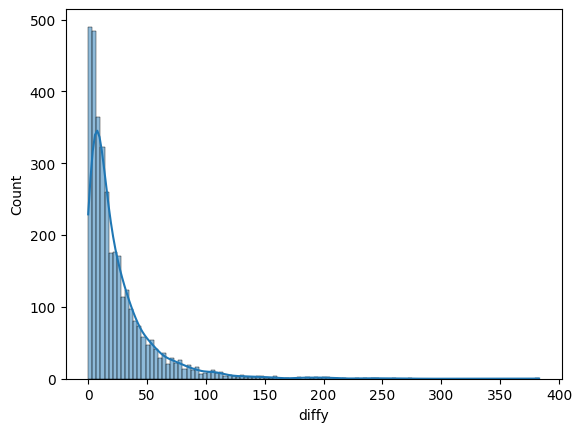

In [13]:
sns.histplot(res['diffy'], kde=True);

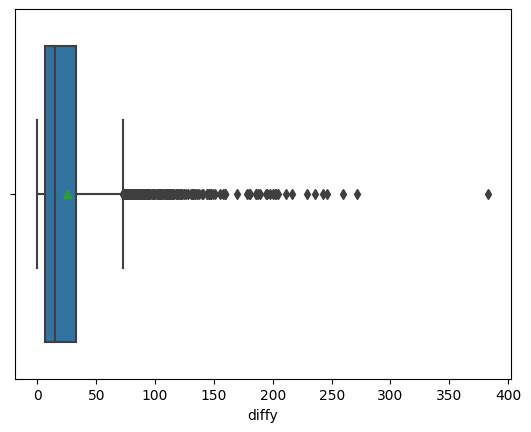

In [14]:
sns.boxplot(x=res['diffy'], showmeans=True);

In [15]:
# outliers - Z-score method
res['diffy'][(stats.zscore(res['diffy']) < -3) | (stats.zscore(res['diffy']) > 3)]

56      148.935719
69      133.095898
80      235.556703
127     159.672534
200     179.435682
           ...    
3075    118.306939
3092    135.890801
3230    124.143992
3240    147.436183
3455    185.717680
Name: diffy, Length: 64, dtype: float64

In [16]:
res['diffy'][(stats.zscore(res['diffy']) < -3) | (stats.zscore(res['diffy']) > 3)]

56      148.935719
69      133.095898
80      235.556703
127     159.672534
200     179.435682
           ...    
3075    118.306939
3092    135.890801
3230    124.143992
3240    147.436183
3455    185.717680
Name: diffy, Length: 64, dtype: float64

In [17]:
top3 = stats.zscore(res['diffy']).sort_values(ascending=False).head()
bot3 = stats.zscore(res['diffy']).sort_values(ascending=False).tail()
print(top3, bot3)

1820    11.851054
2975     8.167972
2284     7.776547
1157     7.315854
1406     7.194628
Name: diffy, dtype: float64 3357   -0.826158
2869   -0.826509
1184   -0.827538
1592   -0.827974
239    -0.828214
Name: diffy, dtype: float64


In [18]:
type(res['diffy'])

pandas.core.series.Series

In [19]:
# outliers - Tukey 5 Number Method
Q1 = res['diffy'].quantile(0.25)
Q3 = res['diffy'].quantile(0.75)
IQR = Q3 - Q1
low_limit = Q1 - (IQR * 1.5)
high_limit = Q3 + (IQR * 1.5)

In [20]:
print(IQR, low_limit, high_limit)

26.5418662566577 -33.70471313459111 72.46275189203968


In [21]:
outliers = list(res[res['diffy'] > high_limit].index)
outliers[0:5]

[3, 12, 15, 35, 38]

In [29]:
res['diff2'] = res['actual'] - res['pred']
res['over_under'] = res['diff2'].apply(lambda x: 'Over' if x < 0 else 'Under')
res[res.index.isin(outliers)]

,actual,pred,diffy,diff2,over_under
3,526,422.226325,103.773675,103.773675,Under
12,542,635.091987,93.091987,-93.091987,Over
15,336,244.482607,91.517393,91.517393,Under
35,868,758.396215,109.603785,109.603785,Under
38,109,203.665367,94.665367,-94.665367,Over
...,...,...,...,...,...
3439,557,642.148454,85.148454,-85.148454,Over
3447,751,666.714463,84.285537,84.285537,Under
3455,116,301.717680,185.717680,-185.717680,Over
3468,53,166.660819,113.660819,-113.660819,Over


In [30]:
res[res.index.isin(outliers)]

,actual,pred,diffy,diff2,over_under
3,526,422.226325,103.773675,103.773675,Under
12,542,635.091987,93.091987,-93.091987,Over
15,336,244.482607,91.517393,91.517393,Under
35,868,758.396215,109.603785,109.603785,Under
38,109,203.665367,94.665367,-94.665367,Over
...,...,...,...,...,...
3439,557,642.148454,85.148454,-85.148454,Over
3447,751,666.714463,84.285537,84.285537,Under
3455,116,301.717680,185.717680,-185.717680,Over
3468,53,166.660819,113.660819,-113.660819,Over


In [31]:
res[res.index.isin(outliers)]['over_under'].value_counts()

over_under
Under    152
Over      79
Name: count, dtype: int64

In [32]:
test[test.index.isin(outliers)]

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
3,2012-05-29,2,1,5,19,0,2,1,1,0.78,0.7121,0.52,0.3582,526
12,2012-06-16,2,1,6,16,0,6,0,2,0.72,0.6515,0.37,0.1045,542
15,2011-03-22,2,0,3,8,0,2,1,2,0.40,0.4091,0.58,0.2985,336
35,2012-08-07,3,1,8,17,0,2,1,2,0.78,0.7424,0.62,0.1343,868
38,2012-05-15,2,1,5,21,0,2,1,3,0.64,0.6061,0.73,0.2836,109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3439,2012-09-16,3,1,9,15,0,0,0,1,0.64,0.6212,0.41,0.1642,557
3447,2012-07-30,3,1,7,8,0,1,1,2,0.72,0.6970,0.74,0.1045,751
3455,2012-02-29,1,1,2,8,0,3,1,2,0.28,0.2879,0.75,0.1045,116
3468,2011-08-28,3,0,8,9,0,0,0,1,0.66,0.6212,0.74,0.4179,53
